In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# Data

In [2]:
# 生成数据集
# 训练集样本数量
n_train = 50
# 生成训练集特征x_train，范围为[0, 5)，并进行排序
x_train, _ = torch.sort(torch.rand(n_train) * 5)
# 定义函数f，用于生成标签y
def f(x):
    return 2 * torch.sin(x) + x**0.8
# 生成训练集标签y_train，并加上服从正态分布的噪声
y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train,))
# 生成测试集特征x_test，范围为[0, 5)，步长为0.1
x_test = torch.arange(0, 5, 0.1)
# 生成测试集的真实标签y_truth
y_truth = f(x_test)
# 计算测试集样本数量
n_test = len(x_test)
n_test

50

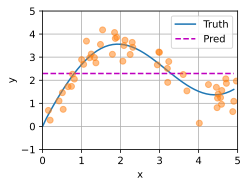

In [3]:
# 绘制核回归结果的图像
def plot_kernel_reg(y_hat):
    # 绘制x_test和对应的真实标签y_truth以及预测标签y_hat的图像
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth','Pred'],
            xlim=[0,5], ylim=[-1,5])
    # 绘制训练集的散点图，用圆圈表示
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)

# 将y_train的均值重复n_test次作为预测标签y_hat  
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
# 调用plot_kernel_reg函数，绘制核回归结果的图像
plot_kernel_reg(y_hat)

In [4]:
y_hat

tensor([2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915,
        2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915,
        2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915,
        2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915,
        2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915, 2.2915,
        2.2915, 2.2915, 2.2915, 2.2915, 2.2915])

# Attention Idea

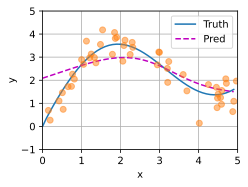

In [5]:
# 非参数注意力汇聚
# 将测试集特征x_test重复n_train次并重新reshape为二维矩阵
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
# 计算注意力权重，通过对特征差值的平方取负并除以2，再进行softmax归一化
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)  
# 注意力权重与训练集标签y_train进行矩阵乘法得到预测标签y_hat
y_hat = torch.matmul(attention_weights, y_train)
# 调用plot_kernel_reg函数，绘制非参数注意力汇聚的核回归结果图像
plot_kernel_reg(y_hat)

this figure shows that, samples are always random, if we want to have a good model performance, we need to be very strict.

In [6]:
X_repeat.shape, x_train.shape, attention_weights.shape, y_train.shape, y_hat.shape

(torch.Size([50, 50]),
 torch.Size([50]),
 torch.Size([50, 50]),
 torch.Size([50]),
 torch.Size([50]))

(x_test, y_test) = x_1, ..., x_50 (fixed step)

(x_train, y_train) = x_1, ..., x_50 (samples)

task: to estimate y_test (y_truth) using (x_train, y_train)

we use y_train to estimate y_test considering the distance between x_train and x_test

for y_k, we think x_k, we want to use our known x_train data to estimate y_k

In [7]:
# x test is fixed step data, x train is sample data
X_repeat[:5, :5], x_train[:5]

(tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1000, 0.1000, 0.1000, 0.1000, 0.1000],
         [0.2000, 0.2000, 0.2000, 0.2000, 0.2000],
         [0.3000, 0.3000, 0.3000, 0.3000, 0.3000],
         [0.4000, 0.4000, 0.4000, 0.4000, 0.4000]]),
 tensor([0.1491, 0.1946, 0.4221, 0.5078, 0.5286]))

In [8]:
x_train.sort(descending=False) == x_train # x train is random

False

In [9]:
-(X_repeat - x_train) ** 2

tensor([[-2.2226e-02, -3.7873e-02, -1.7816e-01,  ..., -2.3765e+01,
         -2.4021e+01, -2.4681e+01],
        [-2.4092e-03, -8.9509e-03, -1.0374e-01,  ..., -2.2800e+01,
         -2.3051e+01, -2.3697e+01],
        [-2.5925e-03, -2.9061e-05, -4.9325e-02,  ..., -2.1855e+01,
         -2.2101e+01, -2.2733e+01],
        ...,
        [-2.0711e+01, -2.0299e+01, -1.8300e+01,  ..., -3.0594e-02,
         -4.0448e-02, -7.1796e-02],
        [-2.1631e+01, -2.1210e+01, -1.9166e+01,  ..., -5.6115e-03,
         -1.0225e-02, -2.8206e-02],
        [-2.2571e+01, -2.2141e+01, -2.0052e+01,  ..., -6.2950e-04,
         -1.2493e-06, -4.6169e-03]])

In [10]:
attention_weights[:5, :5], y_train[:5], attention_weights[:, 0].sum(), attention_weights[0, :].sum()

(tensor([[0.0755, 0.0749, 0.0698, 0.0671, 0.0664],
         [0.0700, 0.0698, 0.0665, 0.0645, 0.0639],
         [0.0647, 0.0648, 0.0632, 0.0618, 0.0614],
         [0.0596, 0.0600, 0.0599, 0.0590, 0.0588],
         [0.0548, 0.0553, 0.0565, 0.0562, 0.0560]]),
 tensor([0.6914, 0.2690, 1.1036, 1.4604, 0.7392]),
 tensor(0.7545),
 tensor(1.0000))

In [11]:
y_hat[:5]

tensor([2.0890, 2.1439, 2.1995, 2.2556, 2.3121])

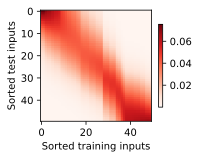

In [12]:
# 注意力权重
# 可视化注意力权重
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), # [1, 1, 50, 50]
                xlabel='Sorted training inputs', ylabel='Sorted test inputs')   

解读heatmap: 颜色深浅代表权重大小，对角线位置表示x_test, x_train距离相近

In [13]:
# 带参数注意力汇聚
# 假定两个张量的形状分别是(n,a,b)和(n,b,c)，它们的批量矩阵乘法输出的形状为(n.a,c)  
# 创建形状为(2,1,4)的张量X，元素全为1
X = torch.ones((2, 1, 4))
# 创建形状为(2,4,6)的张量Y，元素全为1
Y = torch.ones((2, 4, 6))
# 执行批量矩阵乘法，并输出结果的形状
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [14]:
# 使用小批量矩阵乘法来计算小批量数据中的加权平均值
# 创建形状为(2,10)的权重张量，每个权重为0.1
weights = torch.ones((2, 10)) * 0.1
# 创建形状为(2,10)的值张量，从0到19的连续数值
values = torch.arange(20.0).reshape((2, 10))
# 执行小批量矩阵乘法，计算加权平均值
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[[ 4.5000]],

        [[14.5000]]])

# Attention

In [15]:
# 带参数的注意力汇聚
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # 创建形状为(1,)的参数张量w，用于调整注意力权重
        self.w = nn.Parameter(torch.rand((1, ), requires_grad=True)) # scalar
        
    def forward(self, queries, keys, values):
        # 重复queries并调整形状，使其与keys具有相同的列数
        queries = queries.repeat_interleave(keys.shape[1]).reshape(-1, keys.shape[1]) # -1 is the number of query in queries
        # 计算注意力权重，通过调整参数w对注意力进行调节
        self.attention_weights = nn.functional.softmax(-((queries - keys) * self.w) ** 2 / 2, dim=1) # math formula  
        # 执行带参数的注意力汇聚，并返回最终结果的形状调整
        return torch.bmm(self.attention_weights.unsqueeze(1), values.unsqueeze(-1)).reshape(-1) # regard of batch, its weight * y = y_hat

In [16]:
# 将训练数据集转换为键和值
# 将x_train在行维度上重复n_train次，形成一个矩阵X_tile
X_tile = x_train.repeat((n_train, 1))
# 将y_train在行维度上重复n_train次，形成一个矩阵Y_tile
Y_tile = y_train.repeat((n_train, 1))
# 通过掩码操作，从X_tile中排除对角线元素，得到键矩阵keys
keys = X_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape((n_train, -1))  
# 通过掩码操作，从Y_tile中排除对角线元素，得到值矩阵values
values = Y_tile[(1 - torch.eye(n_train)).type(torch.bool)].reshape(n_train, -1)

In [17]:
# X_tile[0, :] == X_tile[1, :]

In [18]:
X_tile.shape, Y_tile.shape, keys.shape, values.shape

(torch.Size([50, 50]),
 torch.Size([50, 50]),
 torch.Size([50, 49]),
 torch.Size([50, 49]))

In [19]:
keys

tensor([[0.1946, 0.4221, 0.5078,  ..., 4.8749, 4.9011, 4.9679],
        [0.1491, 0.4221, 0.5078,  ..., 4.8749, 4.9011, 4.9679],
        [0.1491, 0.1946, 0.5078,  ..., 4.8749, 4.9011, 4.9679],
        ...,
        [0.1491, 0.1946, 0.4221,  ..., 4.7119, 4.9011, 4.9679],
        [0.1491, 0.1946, 0.4221,  ..., 4.7119, 4.8749, 4.9679],
        [0.1491, 0.1946, 0.4221,  ..., 4.7119, 4.8749, 4.9011]])

In [20]:
x_train.reshape((-1, 1)).repeat_interleave(keys.shape[1]).reshape(-1, keys.shape[1])

tensor([[0.1491, 0.1491, 0.1491,  ..., 0.1491, 0.1491, 0.1491],
        [0.1946, 0.1946, 0.1946,  ..., 0.1946, 0.1946, 0.1946],
        [0.4221, 0.4221, 0.4221,  ..., 0.4221, 0.4221, 0.4221],
        ...,
        [4.8749, 4.8749, 4.8749,  ..., 4.8749, 4.8749, 4.8749],
        [4.9011, 4.9011, 4.9011,  ..., 4.9011, 4.9011, 4.9011],
        [4.9679, 4.9679, 4.9679,  ..., 4.9679, 4.9679, 4.9679]])

In [21]:
# X_tile, Y_tile

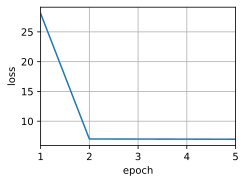

In [22]:
# 训练带参数的注意力汇聚模型
# 创建带参数的注意力汇聚模型
net = NWKernelRegression()
# 创建均方误差损失函数，用于计算损失
loss = nn.MSELoss(reduction='none')
# 创建随机梯度下降优化器，用于参数更新
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
# 创建动画绘制器，用于绘制损失曲线
animator = d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[1,5])

# 遍历5次
for epoch in range(5):
    # 清零梯度
    trainer.zero_grad()

    # x_train is our queries in train mode
    y_hat = net(x_train, keys, values) 

    # 计算损失
    l = loss(y_hat, y_train) / 2
    # 反向传播，计算gradient of self.w
    l.sum().backward()
    # update self.w
    trainer.step()
    # 打印当前的损失
    print(f'epoch {epoch+1}, loss {float(l.sum()):.6f}')
    # 绘制损失曲线
    animator.add(epoch+1, float(l.sum()))

In [23]:
net.w

Parameter containing:
tensor([7.0686], requires_grad=True)

tensor([0.5297, 0.5319, 0.5999, 0.8033, 1.0605, 1.2692, 1.5062, 1.7751, 2.0490,
        2.4110, 2.8045, 3.0236, 3.0883, 3.1246, 3.2454, 3.4578, 3.6386, 3.6820,
        3.6700, 3.6259, 3.5289, 3.4397, 3.4094, 3.4152, 3.4299, 3.4381, 3.3142,
        2.9946, 2.9680, 2.9549, 2.8761, 2.7145, 2.5547, 2.4638, 2.3612, 2.1312,
        1.9460, 1.7827, 1.4352, 0.8112, 0.5502, 0.8587, 1.2865, 1.3935, 1.3503,
        1.3475, 1.3972, 1.4485, 1.4207, 1.3574],
       grad_fn=<ReshapeAliasBackward0>)
tensor([[0.5297],
        [0.5319],
        [0.5999],
        [0.8033],
        [1.0605],
        [1.2692],
        [1.5062],
        [1.7751],
        [2.0490],
        [2.4110],
        [2.8045],
        [3.0236],
        [3.0883],
        [3.1246],
        [3.2454],
        [3.4578],
        [3.6386],
        [3.6820],
        [3.6700],
        [3.6259],
        [3.5289],
        [3.4397],
        [3.4094],
        [3.4152],
        [3.4299],
        [3.4381],
        [3.3142],
        [2.9946],
       

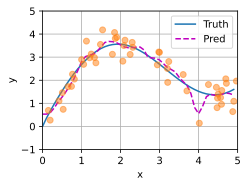

In [24]:
# 预测结果绘制
# 将训练数据集的输入在行维度上重复n_test次，形成键矩阵keys
keys = x_train.repeat((n_test, 1))
# 将训练数据集的输出在行维度上重复n_test次，形成值矩阵values
values = y_train.repeat((n_test, 1))

# 使用训练好的模型进行预测，得到预测结果y_hat
# x_test is our queries, here we dont need  
y_hat = net(x_test, keys, values)

print(y_hat)

# change y_hat from dim1 to column vector
y_hat = y_hat.unsqueeze(1).detach()

print(y_hat)

# 绘制预测结果
plot_kernel_reg(y_hat)

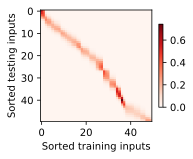

In [25]:
# 曲线在注意力权重较大的区域变得更不平滑
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                 xlabel='Sorted training inputs', ylabel='Sorted testing inputs')   

解读heatmap: 颜色深浅代表权重大小，对角线位置表示x_test, x_train距离相近

这个热力图表示了，不平滑的地方会更多分配注意力权重